In [1]:
# Versiune Python
import sys; print(sys.version)

# Importuri de baza
#pentru datele tabelara
import pandas as pd
#operatii numerice,vectori,matrici
import numpy as np
#expresii regulate pentru curatare text
import re
from pathlib import Path

# Scikit-learn
from sklearn.model_selection import train_test_split
#trans textul in features numerice count in nr aparitii si tf in frecventa ponderata
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#multinomial frecv termeni, bernoulli prez/absenta
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
)

# NLTK pentru stopwords / lemmatizare
#stopwords : elimin cuvinte foarte frecv de ex is, the, and
#lemetizare: forma canonica a cuvintelor
import nltk
try:
    _ = nltk.corpus.stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    from nltk.stem import WordNetLemmatizer
except Exception:
    nltk.download('wordnet')
    from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt


3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
CSV_PATH = Path('/content/drive/MyDrive/AMDA/Restaurant Reviews.csv')
assert CSV_PATH.exists(), f"Nu gasesc {CSV_PATH.resolve()}"

df = pd.read_csv(CSV_PATH)
df.head()


,Review,Liked
0,Wow... Loved this place.,1.0
1,Crust is not good.,0.0
2,Not tasty and the texture was just nasty.,0.0
3,Stopped by during the late May bank holiday of...,1.0
4,The selection on the menu was great and so wer...,1.0


Analiza exploratorie a datelor (EDA): dtarea datasetului inainte de preprocesare

In [3]:
#cate recenzii, cate valori lipsa
print(df.info())
print("\nDistribuția etichetei (Liked):")
#analizez cate recenzii pozitive sau negative sau fara val sunt
print(df['Liked'].value_counts(dropna=False))

# lungimea textelor (in cuvinte)
#cate cuvinte, in medie cate cuv are un review, majoritatea sunt scurte
df['text_len'] = df['Review'].astype(str).str.split().apply(len)
df['text_len'].describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2220 entries, 0 to 2219
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  2220 non-null   object 
 1   Liked   2117 non-null   float64
dtypes: float64(1), object(1)
memory usage: 34.8+ KB
None

Distribuția etichetei (Liked):
Liked
1.0    1099
0.0    1018
NaN     103
Name: count, dtype: int64


,text_len
count,2220.000000
mean,9.400901
std,4.503126
min,1.000000
25%,7.000000
50%,8.000000
75%,10.000000
max,32.000000


/tmp/ipython-input-3495648828.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="Blues")


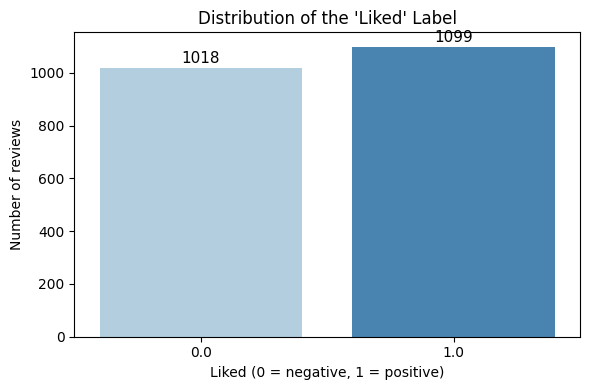

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asigură-te că ai df curățat (df['Liked'] deja int, fără NaN)
label_counts = df['Liked'].value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Blues")

plt.title("Distribution of the 'Liked' Label")
plt.xlabel("Liked (0 = negative, 1 = positive)")
plt.ylabel("Number of reviews")

# Adaug numere peste bare (pentru un look profesionist)
for i, v in enumerate(label_counts.values):
    plt.text(i, v + 20, str(v), ha='center', fontsize=11)

plt.tight_layout()
plt.show()


In [5]:
#pentru baza de date WordNet
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [6]:
from nltk.corpus import stopwords
#cuvintele frecv the,is...
stop_words = set(stopwords.words('english'))
stop_words = set(stopwords.words('english')) - {'not','no','never'}

#micsorez vocabularul sa am mai putine features
lemmatizer = WordNetLemmatizer()

#functia de curatare
def clean_text(s: str, do_stop=True, do_lemma=True):
    s = s.lower()
    s = re.sub(r'https?://\S+|www\.\S+', ' ', s)   #elimnin linkuri/urls
    s = re.sub(r'[^a-z\s]', ' ', s)                # păstrează doar litere/spatii
    tokens = s.split()  #fiecare cuvant devine un token
    if do_stop:
        tokens = [t for t in tokens if t not in stop_words]
    if do_lemma:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)
#am facut aces lucru pentru ca naive bayens trateaza frecventa cuvintelor, astfel amaze,amazing sunt acelasi cuvant

#am 2 variante a textului, cu lemetizare si stop si una minimala
#astfel vad cat contribuie fiecare prelucrare la performanta
df['clean_preproc']  = df['Review'].astype(str).apply(lambda s: clean_text(s, True, True))
df['clean_minimal']  = df['Review'].astype(str).apply(lambda s: clean_text(s, False, False))

df[['Review','clean_preproc','clean_minimal']].head(10)


,Review,clean_preproc,clean_minimal
0,Wow... Loved this place.,wow loved place,wow loved this place
1,Crust is not good.,crust not good,crust is not good
2,Not tasty and the texture was just nasty.,not tasty texture nasty,not tasty and the texture was just nasty
3,Stopped by during the late May bank holiday of...,stopped late may bank holiday rick steve recom...,stopped by during the late may bank holiday of...
4,The selection on the menu was great and so wer...,selection menu great price,the selection on the menu was great and so wer...
5,Now I am getting angry and I want my damn pho.,getting angry want damn pho,now i am getting angry and i want my damn pho
6,Honeslty it didn't taste THAT fresh.,honeslty taste fresh,honeslty it didn t taste that fresh
7,The potatoes were like rubber and you could te...,potato like rubber could tell made ahead time ...,the potatoes were like rubber and you could te...
8,The fries were great too.,fry great,the fries were great too
9,A great touch.,great touch,a great touch


In [7]:
# 1) elimină rândurile cu etichetă lipsă
df = df.dropna(subset=['Liked']).copy()

# 2) asigură tipul numeric pentru etichetă (0/1)
df['Liked'] = df['Liked'].astype(int)

# 3) dacă nu ai rulat deja, elimină textele goale după curățare
# (înlocuiește 'clean_preproc' cu coloana ta curățată)
empty_mask = df['clean_preproc'].astype(str).str.strip().eq('')
df = df[~empty_mask].copy()

# 4) elimină și Review-urile NaN inițiale (dacă există)
df = df.dropna(subset=['Review']).copy()

# verificare finală
print(df['Liked'].value_counts())
print("rows:", df.shape[0])


Liked
1    1099
0    1017
Name: count, dtype: int64
rows: 2116


In [8]:
def run_experiment(
    text_series: pd.Series,  # coloana de texte (de ex. df['clean_preproc'])
    labels: pd.Series,       # etichete (de ex. df['Liked'])
    vec_type: str = 'tfidf',          # alegem reprezentarea: 'tfidf' sau 'count'
    max_features: int = 1500,         # câte cuvinte păstrăm în vocabular
    ngram_range=(1,1),                # (1,1) = doar unigrame; (1,2) = unigrame + bigrame
    model_type: str = 'multinomial',  # 'multinomial' sau 'bernoulli'
    alpha: float = 1.0,               # smoothing (previne probabilități 0)
    test_size: float = 0.2,           # 20% din date merg în setul de test
    random_state: int = 42
):
    # 0) împărțim MAI ÎNTÂI în train/test pe text brut (evităm data leakage)
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        text_series.astype(str).values,
        labels.values,
        test_size=test_size,
        random_state=random_state,
        stratify=labels.values   # păstrăm proporția claselor
    )

    # 1) Vectorizare (transformă text în numere)
    if vec_type == 'tfidf':
        # TF-IDF: frecvență ponderată (cuvintele rare au greutate mai mare)
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range
        )
    elif vec_type == 'count':
        # Count: număr de apariții; binary=True pt. BernoulliNB (prezență/absență)
        vectorizer = CountVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            binary=(model_type == 'bernoulli')
        )
    else:
        raise ValueError("vec_type trebuie să fie 'tfidf' sau 'count'")

    # învățăm vocabularul DOAR pe train și vectorizăm train + test cu același vocabular
    X_train = vectorizer.fit_transform(X_train_text)
    X_test  = vectorizer.transform(X_test_text)

    # 2) Alegem modelul Naive Bayes
    if model_type == 'multinomial':
        # MultinomialNB: folosește frecvențele termenilor (ideal cu Count/TF-IDF)
        model = MultinomialNB(alpha=alpha)
    elif model_type == 'bernoulli':
        # BernoulliNB: lucrează cu features binare (0/1 – prezent/absent)
        model = BernoulliNB(alpha=alpha)
    else:
        raise ValueError("model_type trebuie 'multinomial' sau 'bernoulli'")

    # 3) Antrenăm modelul pe setul de train
    model.fit(X_train, y_train)

    # 4) Predictii pe setul de test
    y_pred = model.predict(X_test)

    # 5) Calculăm metricile de evaluare
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred,
        average='binary',   # avem clasificare binară 0/1
        pos_label=1,        # considerăm clasa 1 = "pozitiv"
        zero_division=0
    )

    cm = confusion_matrix(y_test, y_pred)

    # 6) AUC (dacă modelul suportă predict_proba)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]  # probabilitatea pentru clasa 1
        auc = roc_auc_score(y_test, y_proba)
    except Exception:
        y_proba, auc = None, None

    # 7) returnăm scorurile + obiectele utile pentru analize ulterioare
    return {
        'acc': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc,
        'cm': cm,
        'y_test': y_test,
        'y_pred': y_pred,
        'model': model,
        'vectorizer': vectorizer
    }


In [9]:
res_base = run_experiment(
    text_series=df['clean_preproc'],
    labels=df['Liked'],
    vec_type='tfidf',
    max_features=1500,
    ngram_range=(1,1),
    model_type='multinomial',
    alpha=1.0
)
print({
    'Accuracy': round(res_base['acc'],4),
    'Precision': round(res_base['precision'],4),
    'Recall': round(res_base['recall'],4),
    'F1': round(res_base['f1'],4),
    'AUC': None if res_base['auc'] is None else round(res_base['auc'],4)
})
print("\nClassification report:\n")
print(classification_report(res_base['y_test'], res_base['y_pred'], digits=4))


{'Accuracy': 0.9127, 'Precision': 0.9103, 'Recall': 0.9227, 'F1': 0.9165, 'AUC': np.float64(0.9711)}

Classification report:

              precision    recall  f1-score   support

           0     0.9154    0.9020    0.9086       204
           1     0.9103    0.9227    0.9165       220

    accuracy                         0.9127       424
   macro avg     0.9129    0.9123    0.9126       424
weighted avg     0.9128    0.9127    0.9127       424



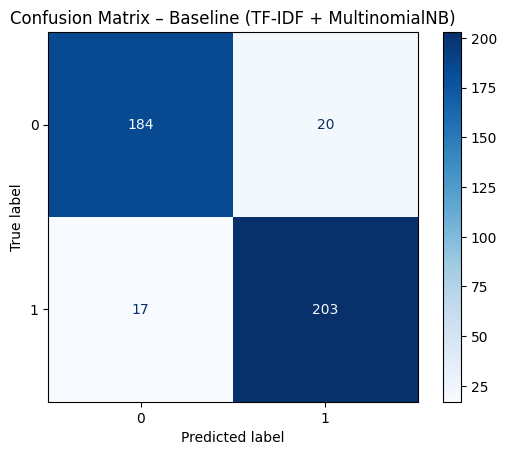

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix=res_base['cm'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix – Baseline (TF-IDF + MultinomialNB)')
plt.show()


In [11]:
experiments = [
    # vec,   ngrams, model,        alpha, max_features, text_col
    ('tfidf', (1,1), 'multinomial', 1.0,   1500,        'clean_preproc'),
    ('tfidf', (1,2), 'multinomial', 1.0,   5000,        'clean_preproc'),
    ('count', (1,1), 'multinomial', 1.0,   1500,        'clean_preproc'),
    ('count', (1,1), 'bernoulli',   1.0,   1500,        'clean_minimal'),
    ('tfidf', (1,1), 'multinomial', 0.1,   1500,        'clean_preproc'),
    ('tfidf', (1,1), 'multinomial', 5.0,   1500,        'clean_preproc'),
]

rows = []
for vec_type, ngrams, model_type, alpha, max_feat, text_col in experiments:
    r = run_experiment(
        text_series=df[text_col],
        labels=df['Liked'],
        vec_type=vec_type,
        max_features=max_feat,
        ngram_range=ngrams,
        model_type=model_type,
        alpha=alpha
    )
    rows.append({
        'vec': vec_type,
        'ngrams': f'{ngrams[0]}-{ngrams[1]}',
        'model': model_type,
        'alpha': alpha,
        'max_features': max_feat,
        'text_col': text_col,
        'acc': r['acc'],
        'precision': r['precision'],
        'recall': r['recall'],
        'f1': r['f1'],
        'auc': r['auc']
    })

results_df = pd.DataFrame(rows).sort_values(by='f1', ascending=False)
results_df


,vec,ngrams,model,alpha,max_features,text_col,acc,precision,recall,f1,auc
0,tfidf,1-1,multinomial,1.0,1500,clean_preproc,0.912736,0.910314,0.922727,0.916479,0.971101
2,count,1-1,multinomial,1.0,1500,clean_preproc,0.912736,0.914027,0.918182,0.916100,0.969184
3,count,1-1,bernoulli,1.0,1500,clean_minimal,0.910377,0.955000,0.868182,0.909524,0.958935
4,tfidf,1-1,multinomial,0.1,1500,clean_preproc,0.903302,0.904977,0.909091,0.907029,0.973396
1,tfidf,1-2,multinomial,1.0,5000,clean_preproc,0.900943,0.893805,0.918182,0.905830,0.969920
5,tfidf,1-1,multinomial,5.0,1500,clean_preproc,0.893868,0.869198,0.936364,0.901532,0.963012


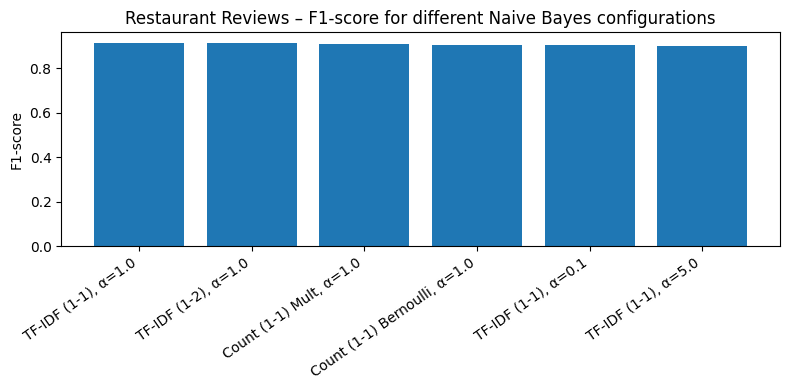

In [12]:
import matplotlib.pyplot as plt

# facem o copie și îi dăm etichete mai “umane”
plot_df = results_df.copy().reset_index(drop=True)

label_map = {
    0: "TF-IDF (1-1), α=1.0",
    1: "TF-IDF (1-2), α=1.0",
    2: "Count (1-1) Mult, α=1.0",
    3: "Count (1-1) Bernoulli, α=1.0",
    4: "TF-IDF (1-1), α=0.1",
    5: "TF-IDF (1-1), α=5.0",
}
plot_df["config_label"] = plot_df.index.map(label_map)

plt.figure(figsize=(8,4))
plt.bar(plot_df["config_label"], plot_df["f1"])
plt.xticks(rotation=35, ha="right")
plt.ylabel("F1-score")
plt.title("Restaurant Reviews – F1-score for different Naive Bayes configurations")
plt.tight_layout()
plt.show()


In [13]:
def top_terms_multinomial(model, vectorizer, k=20):
    feat_names = np.array(vectorizer.get_feature_names_out())
    if hasattr(model, 'feature_log_prob_') and model.feature_log_prob_.shape[0] == 2:
        scores = model.feature_log_prob_[1] - model.feature_log_prob_[0]  # log-odds 1 vs 0
        top_pos_idx = np.argsort(scores)[-k:][::-1]
        top_neg_idx = np.argsort(scores)[:k]
        return feat_names[top_pos_idx], feat_names[top_neg_idx]
    return np.array([]), np.array([])

pos_words, neg_words = top_terms_multinomial(res_base['model'], res_base['vectorizer'], k=20)
print("Top positive terms:", list(pos_words))
print("Top negative terms:", list(neg_words))


Top positive terms: ['great', 'exceptional', 'satisfied', 'provided', 'maintained', 'generous', 'recommendation', 'attentive', 'inviting', 'exquisite', 'range', 'minimal', 'clean', 'efficient', 'welcoming', 'cozy', 'mouthwatering', 'flavorful', 'delight', 'excellent']
Top negative terms: ['lacked', 'slow', 'poor', 'limited', 'inattentive', 'tasteless', 'dirty', 'overpriced', 'uncomfortable', 'no', 'terrible', 'unclean', 'sticky', 'unhelpful', 'disorganized', 'unsatisfied', 'unprofessional', 'long', 'not', 'rude']


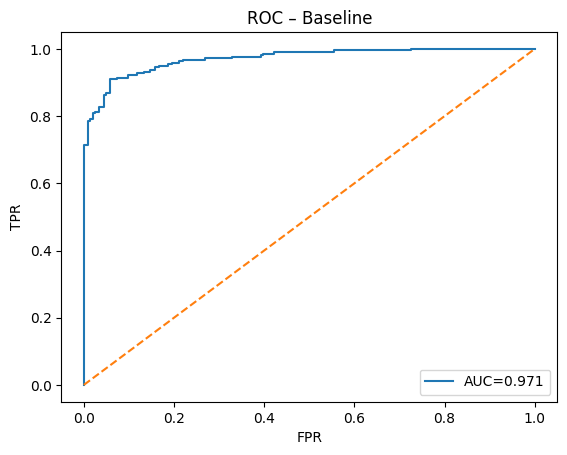

In [14]:
if res_base['auc'] is not None:
    y_test = res_base['y_test']
    y_proba = res_base['model'].predict_proba(res_base['vectorizer'].transform(df['clean_preproc']))  # atenție: pe tot setul, doar demonstrativ
    # corect ar fi să refacem exact X_test folosit mai sus; pentru simplitate, refacem split-ul:
    from sklearn.model_selection import train_test_split
    X_all = res_base['vectorizer'].transform(df['clean_preproc'])
    X_train, X_test, y_train, y_test = train_test_split(X_all, df['Liked'].values, test_size=0.2, random_state=42, stratify=df['Liked'].values)
    y_proba = res_base['model'].predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC={roc_auc_score(y_test, y_proba):.3f}')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC – Baseline'); plt.legend()
    plt.show()


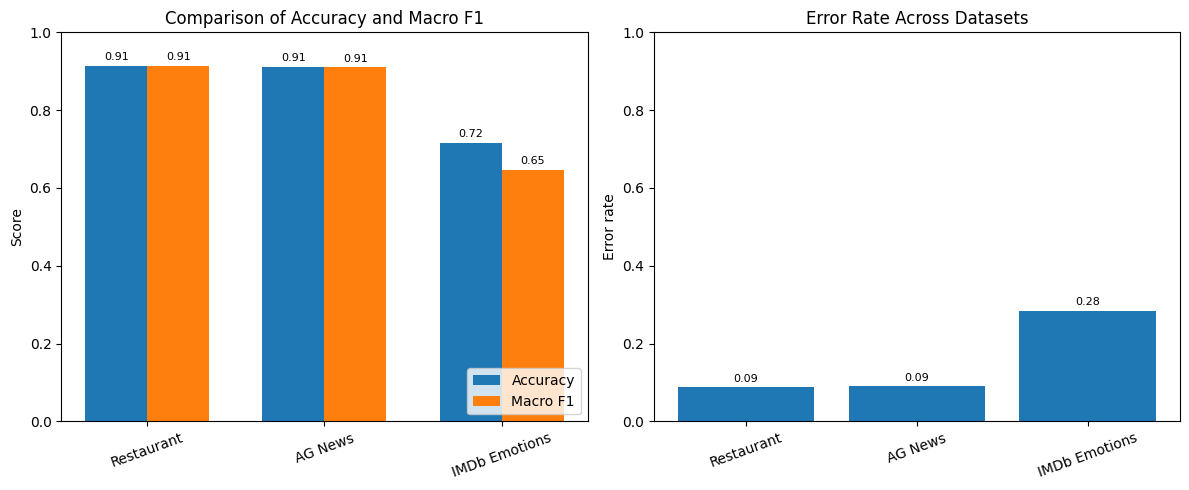

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# =========================
# 1. Hard-code metrics
# =========================

datasets = ["Restaurant", "AG News", "IMDb Emotions"]

# Accuracy
acc = np.array([
    0.9127,  # Restaurant baseline (TF-IDF unigrams + MNB)
    0.9101,  # AG_A3 (TF-IDF uni+bi + MNB)
    0.7161   # IMDb B1 (Count uni + genres)
])

# Macro F1 (sau F1 pentru Restaurant)
f1_macro = np.array([
    0.9126,  # macro avg F1 din classification_report la Restaurant
    0.9098,  # F1_macro AG_A3
    0.6455   # F1_macro IMDb B1
])

error_rate = 1 - acc

# =========================
# 2. Figure cu 2 subplots
# =========================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ---- (a) Accuracy vs F1_macro ----
ax = axes[0]
x = np.arange(len(datasets))
width = 0.35

ax.bar(x - width/2, acc, width, label="Accuracy")
ax.bar(x + width/2, f1_macro, width, label="Macro F1")

ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=20)
ax.set_ylim(0, 1.0)
ax.set_ylabel("Score")
ax.set_title("Comparison of Accuracy and Macro F1")
ax.legend(loc="lower right")

# opțional: valori deasupra barelor
for i in range(len(datasets)):
    ax.text(x[i] - width/2, acc[i] + 0.01, f"{acc[i]:.2f}", ha='center', va='bottom', fontsize=8)
    ax.text(x[i] + width/2, f1_macro[i] + 0.01, f"{f1_macro[i]:.2f}", ha='center', va='bottom', fontsize=8)

# ---- (b) Error rate = 1 - Accuracy ----
ax2 = axes[1]
ax2.bar(x, error_rate)
ax2.set_xticks(x)
ax2.set_xticklabels(datasets, rotation=20)
ax2.set_ylim(0, 1.0)
ax2.set_ylabel("Error rate")
ax2.set_title("Error Rate Across Datasets")

for i in range(len(datasets)):
    ax2.text(x[i], error_rate[i] + 0.01, f"{error_rate[i]:.2f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()
